In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pickle
import torch
sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from supervised_learning import test
from ensemble import test as test_ensemble
from get_data import get_dataloader
from rus import *

#### dataset clustering

In [3]:
def clustering(X, pca=False, n_clusters=20, n_components=5):
  X = np.nan_to_num(X)
  if len(X.shape) > 2:
    X = X.reshape(X.shape[0],-1)
  if pca:
    # print(np.any(np.isnan(X)), np.all(np.isfinite(X)))
    X = normalize(X)
    X = PCA(n_components=n_components).fit_transform(X)
  kmeans = KMeans(n_clusters=n_clusters).fit(X)
  return kmeans.labels_, X

In [4]:
for setting in ['redundancy', 'uniqueness0', 'uniqueness1', 'synergy']:
  data_dir = 'synthetic/experiments2/DATA_{}.pickle'.format(setting)
  dataset = pd.read_pickle(data_dir)
  n_components = 2
  data_cluster = dict()
  for split in ['valid2', 'test']:
    data_cluster[split] = dict()
    data = dataset[split]
    kmeans_0, data_0 = clustering(data['0'], pca=True, n_components=n_components, n_clusters=20)
    data_cluster[split]['0'] = kmeans_0.reshape(-1,1)
    kmeans_1, data_1 = clustering(data['1'], pca=True, n_components=n_components, n_clusters=20)
    data_cluster[split]['1'] = kmeans_1.reshape(-1,1)
    data_cluster[split]['label'] = data['label']
  with open('synthetic/experiments2/DATA_{}_cluster.pickle'.format(setting), 'wb') as f:
      pickle.dump(data_cluster, f)

for i in range(1, 7):
  data_dir = 'synthetic/experiments2/DATA_mix{}.pickle'.format(i)
  dataset = pd.read_pickle(data_dir)
  n_components = 2
  data_cluster = dict()
  for split in ['valid2', 'test']:
    data_cluster[split] = dict()
    data = dataset[split]
    kmeans_0, data_0 = clustering(data['0'], pca=True, n_components=n_components, n_clusters=20)
    data_cluster[split]['0'] = kmeans_0.reshape(-1,1)
    kmeans_1, data_1 = clustering(data['1'], pca=True, n_components=n_components, n_clusters=20)
    data_cluster[split]['1'] = kmeans_1.reshape(-1,1)
    data_cluster[split]['label'] = data['label']
  with open('synthetic/experiments2/DATA_mix{}_cluster.pickle'.format(i), 'wb') as f:
      pickle.dump(data_cluster, f)

for i in range(1, 6):
    data_dir = 'synthetic/experiments2/DATA_synthetic{}.pickle'.format(i)
    dataset = pd.read_pickle(data_dir)
    n_components = 2
    data_cluster = dict()
    for split in ['valid2', 'test']:
        data_cluster[split] = dict()
        data = dataset[split]
        kmeans_0, data_0 = clustering(data['0'], pca=True, n_components=n_components, n_clusters=20)
        data_cluster[split]['0'] = kmeans_0.reshape(-1,1)
        kmeans_1, data_1 = clustering(data['1'], pca=True, n_components=n_components, n_clusters=20)
        data_cluster[split]['1'] = kmeans_1.reshape(-1,1)
        data_cluster[split]['label'] = data['label']
    with open('synthetic/experiments2/DATA_synthetic{}_cluster.pickle'.format(i), 'wb') as f:
        pickle.dump(data_cluster, f)

#### dataset measures

In [28]:
if os.path.isfile('synthetic/experiments2/datasets.pickle'):
    with open('synthetic/experiments2/datasets.pickle', 'rb') as f:
        results = pickle.load(f)
else:
    results = dict()
SETTINGS = ['redundancy', 'uniqueness0', 'uniqueness1', 'synergy'] + ['mix{}'.format(i) for i in range(1,7)] + ['synthetic{}'.format(i) for i in range(1,6)]
for setting in ['mix6']:
    with open('synthetic/experiments2/DATA_{}_cluster.pickle'.format(setting), 'rb') as f:
        dataset = pickle.load(f)
    print(setting)
    data = (dataset['test']['0'], dataset['test']['1'], dataset['test']['label'])
    P, maps = convert_data_to_distribution(*data)
    result = get_measure(P)
    results[setting] = result
    print()

with open('synthetic/experiments2/datasets.pickle', 'wb') as f:
    pickle.dump(results, f)

mix6
Redundancy 0.10009443254017347
Unique 4.732578094827056e-15
Unique 0.0421881964240354
Synergy 0.04911458973854771



#### model selection

In [5]:
with open('synthetic/experiments2/results.pickle', 'rb') as f:
    results = pickle.load(f)
print(results['additive']['redundancy'].keys())
with open('synthetic/experiments2/datasets.pickle', 'rb') as f:
    datasets = pickle.load(f)
METHODS = ['additive', 'agree', 'align', 'early_fusion', 'elem', 'recon', 'mi', 'mult', 'outer', 'lower']
SETTINGS = ['redundancy', 'uniqueness0', 'uniqueness1', 'synergy', 'mix1', 'mix2', 'mix3', 'mix4', 'mix5', 'mix6']
MEASURES = ['redundancy', 'unique1', 'unique2', 'synergy']
MODEL_SELECTION = ['synthetic{}'.format(i) for i in range(1,6)]
print(datasets.keys())

dict_keys(['redundancy', 'unique1', 'unique2', 'synergy', 'acc', 'params'])
dict_keys(['redundancy', 'uniqueness0', 'uniqueness1', 'synergy', 'mix1', 'mix2', 'mix3', 'mix4', 'mix5', 'synthetic1', 'synthetic2', 'synthetic3', 'synthetic4', 'synthetic5', 'mix6'])


In [4]:
normalized_results = dict()
normalized_datasets = dict()
for method in results:
    normalized_results[method] = dict()
    for setting in SETTINGS:
        normalized_results[method][setting] = dict()
        normalized_datasets[setting] = dict()
        results_total = sum([results[method][setting][measure] for measure in ['redundancy', 'unique1', 'unique2', 'synergy']])
        datasets_total = sum([datasets[setting][measure] for measure in ['redundancy', 'unique1', 'unique2', 'synergy']])
        for measure in MEASURES:
            normalized_results[method][setting][measure] = results[method][setting][measure] / results_total
            normalized_datasets[setting][measure] = datasets[setting][measure] / datasets_total

In [37]:
accs = [results[method][setting]['acc'] for setting in results[method] for method in METHODS]
for setting in SETTINGS:
    measures = sorted([(results[method][setting]['acc'], method) for method in METHODS])
    print(setting, measures[-3:])

redundancy [(0.7422222222222222, 'recon'), (0.7433333333333333, 'additive'), (0.7461111111111111, 'lower')]
uniqueness0 [(0.7316666666666667, 'outer'), (0.7338888888888889, 'early_fusion'), (0.7361111111111112, 'recon')]
uniqueness1 [(0.7427777777777778, 'align'), (0.7433333333333333, 'additive'), (0.7438888888888889, 'outer')]
synergy [(0.735, 'align'), (0.7355555555555555, 'agree'), (0.7438888888888889, 'recon')]
mix1 [(0.6594444444444445, 'recon'), (0.6605555555555556, 'agree'), (0.6633333333333333, 'align')]
mix2 [(0.7116666666666667, 'recon'), (0.7205555555555555, 'agree'), (0.7233333333333334, 'align')]
mix3 [(0.7294444444444445, 'recon'), (0.7361111111111112, 'lower'), (0.7455555555555555, 'agree')]
mix4 [(0.7044444444444444, 'early_fusion'), (0.705, 'lower'), (0.71, 'recon')]
mix5 [(0.6555555555555556, 'additive'), (0.6555555555555556, 'recon'), (0.66, 'align')]
mix6 [(0.7233333333333334, 'additive'), (0.7233333333333334, 'mult'), (0.725, 'align')]


In [38]:
agreement = dict()
for method in results:
    agreement[method] = dict()
    for setting in SETTINGS:
        agreement[method][setting] = dict()
        for measure in ['redundancy', 'unique1', 'unique2', 'synergy']:
            # agreement[method][setting][measure] = normalized_datasets[setting][measure] * (results[method][setting][measure] - datasets[setting][measure])
            agreement[method][setting][measure] = normalized_datasets[setting][measure] * results[method][setting][measure]

In [39]:
# plot utils

def plot(X, y, xlabel, ylabel, label=None, saved_path=None, fit=False, plot='scatter'):
    fig, ax = plt.subplots(figsize=(4,4))
    if plot == 'scatter':
        ax.scatter(X, y)
    elif plot == 'line':
        plt.plot(X, y)
    if label:
        for x in label:
            plt.text(x[0], x[1], x[2])
    # else:
    #     plt.plot(X, y)
    # ax.set_title('{} vs {}'.format(xlabel, ylabel))
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if fit:
        p = np.poly1d(np.polyfit(np.array(X), np.array(y), 1))
        fit_x = list(np.arange(100)/1000*4.5)
        fit_y = []
        for x in fit_x:
            fit_y.append(p(x))
        plt.plot(fit_x, fit_y, linestyle='dashed')
    if saved_path:
        fig.savefig(saved_path+'.pdf', bbox_inches='tight')
    plt.show()

('uniqueness0', 'additive') 0.08968748968537002 0.5016666666666667
0.7763136382116782


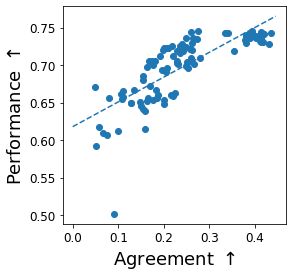

0.8047583682477277


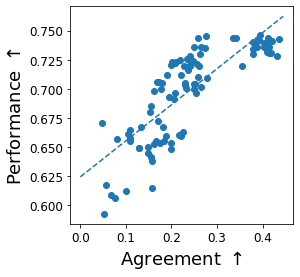

redundancy: lower (agree 0.39412632878107934, acc 0.7461111111111111)
redundancy: recon (agree 0.4149849730414582, acc 0.7422222222222222)
redundancy: agree (agree 0.4202237917210205, acc 0.7411111111111112)
uniqueness0: agree (agree 0.4140355514944794, acc 0.7305555555555555)
uniqueness0: lower (agree 0.4183832926407891, acc 0.7305555555555555)
uniqueness0: align (agree 0.43131614744130564, acc 0.7277777777777777)
uniqueness1: outer (agree 0.4126942083745158, acc 0.7438888888888889)
uniqueness1: recon (agree 0.4132064218816007, acc 0.7361111111111112)
uniqueness1: align (agree 0.4356037424462337, acc 0.7427777777777778)
synergy: recon (agree 0.25869843200208165, acc 0.7438888888888889)
synergy: agree (agree 0.2638104134123337, acc 0.7355555555555555)
synergy: align (agree 0.2733781711400606, acc 0.735)
mix1: agree (agree 0.21557368873226873, acc 0.6605555555555556)
mix1: recon (agree 0.21992273064012036, acc 0.6594444444444445)
mix1: align (agree 0.22541190803943534, acc 0.66333333333

In [40]:
ratio = dict()
for method in METHODS:
    ratio[method] = dict()
    for setting in SETTINGS:
        tmp = 0
        for measure in ['redundancy', 'unique1', 'unique2', 'synergy']:
            tmp += agreement[method][setting][measure]
        ratio[method][setting] = tmp
measures = [ratio[method][setting] for setting in SETTINGS for method in METHODS]
accs = [results[method][setting]['acc'] for setting in SETTINGS for method in METHODS]
labels = [(setting, method) for setting in SETTINGS for method in METHODS]
measures_tmp = []
accs_tmp = []
for i, acc in enumerate(accs):
    if acc >= 0.55:
        measures_tmp.append(measures[i])
        accs_tmp.append(accs[i])
    else:
        print(labels[i], measures[i], accs[i])
print(np.corrcoef(measures, accs)[0,1])
plot(measures, accs, r'Agreement $\uparrow$', r'Performance $\uparrow$', fit=True)
print(np.corrcoef(measures_tmp, accs_tmp)[0,1])
plot(measures_tmp, accs_tmp, r'Agreement $\uparrow$', r'Performance $\uparrow$', saved_path='figs/agreement_performance', fit=True)
for setting in SETTINGS:
    measures = sorted([(ratio[method][setting], method) for method in METHODS])
    # print(measures[-3:])
    for agree, method in measures[-3:]:
        print("{}: {} (agree {}, acc {})".format(setting, method, agree, results[method][setting]['acc']))

In [18]:
for setting in ['redundancy', 'uniqueness', 'synergy']:
    tmp = []
    print(METHODS)
    for method in METHODS:
        if setting == 'uniqueness':
            measure = (results[method][setting+'0']['unique1']+results[method][setting+'1']['unique2'])/2
        else:
            measure = results[method][setting][setting]
        print('&', round(measure, 2), end=' ')
        tmp.append(measure)
    print('&', '{}$\pm${}'.format(round(np.mean(tmp), 2), round(np.std(tmp), 2)))
    tmp = []
    for method in METHODS:
        if setting == 'uniqueness':
            acc = (results[method][setting+'0']['acc']+results[method][setting+'1']['acc'])/2
        else:
            acc = results[method][setting]['acc']
        print('&', round(acc, 2), end=' ')
        tmp.append(acc)
    print('&', '{}\pm{}'.format(round(np.mean(tmp), 2), round(np.std(tmp), 2)))

['additive', 'agree', 'align', 'early_fusion', 'elem', 'recon', 'mi', 'mult', 'outer', 'lower']
& 0.44 & 0.56 & 0.52 & 0.51 & 0.36 & 0.55 & 0.26 & 0.46 & 0.51 & 0.52 & 0.47$\pm$0.09
& 0.74 & 0.74 & 0.74 & 0.74 & 0.71 & 0.74 & 0.69 & 0.72 & 0.74 & 0.75 & 0.73\pm0.02
['additive', 'agree', 'align', 'early_fusion', 'elem', 'recon', 'mi', 'mult', 'outer', 'lower']
& 0.27 & 0.54 & 0.57 & 0.5 & 0.33 & 0.54 & 0.23 & 0.51 & 0.54 & 0.53 & 0.46$\pm$0.12
& 0.56 & 0.74 & 0.74 & 0.74 & 0.7 & 0.74 & 0.7 & 0.73 & 0.74 & 0.74 & 0.71\pm0.05
['additive', 'agree', 'align', 'early_fusion', 'elem', 'recon', 'mi', 'mult', 'outer', 'lower']
& 0.21 & 0.34 & 0.36 & 0.3 & 0.21 & 0.34 & 0.17 & 0.29 & 0.33 & 0.32 & 0.29$\pm$0.06
& 0.54 & 0.74 & 0.74 & 0.73 & 0.67 & 0.74 & 0.67 & 0.71 & 0.72 & 0.72 & 0.7\pm0.06


In [8]:
print('&', end=' ')
for setting in SETTINGS:
    for measure in MEASURES:
        print('${}$ &'.format(round(datasets[setting][measure], 2)), end=' ')
print('\\\\')

& $0.16$ & $0.0$ & $0.0$ & $0.05$ & $0.0$ & $0.16$ & $0.0$ & $0.05$ & $0.0$ & $0.0$ & $0.17$ & $0.05$ & $0.07$ & $0.0$ & $0.01$ & $0.14$ & $0.04$ & $0.01$ & $0.0$ & $0.07$ & $0.04$ & $0.06$ & $0.0$ & $0.07$ & $0.07$ & $0.0$ & $0.0$ & $0.12$ & $0.1$ & $0.0$ & $0.01$ & $0.07$ & $0.03$ & $0.0$ & $0.04$ & $0.05$ & $0.1$ & $0.0$ & $0.04$ & $0.05$ & \\


In [44]:
model_selection = dict()
for setting in SETTINGS:
    measures = sorted([(results[method][setting]['acc'], method) for method in METHODS])
    model_selection[setting] = measures[-3:]
# model_selection

In [43]:
normalized_new_results = dict()
normalized_new_datasets = dict()
for method in results:
    normalized_new_results[method] = dict()
    for setting in MODEL_SELECTION:
        normalized_new_results[method][setting] = dict()
        normalized_new_datasets[setting] = dict()
        results_total = sum([results[method][setting][measure] for measure in ['redundancy', 'unique1', 'unique2', 'synergy']])
        datasets_total = sum([datasets[setting][measure] for measure in ['redundancy', 'unique1', 'unique2', 'synergy']])
        for measure in MEASURES:
            normalized_new_results[method][setting][measure] = results[method][setting][measure] / results_total
            normalized_new_datasets[setting][measure] = datasets[setting][measure] / datasets_total

In [45]:
accs = [results[method][setting]['acc'] for setting in MODEL_SELECTION for method in METHODS]
model_selection_best = dict()
for setting in MODEL_SELECTION:
    measures = sorted([(results[method][setting]['acc'], method) for method in METHODS])
    model_selection_best[setting] = results[measures[-1][1]][setting]['acc']
    print(setting, measures[-3:])

synthetic1 [(0.6477777777777778, 'agree'), (0.6488888888888888, 'align'), (0.6488888888888888, 'recon')]
synthetic2 [(0.7172222222222222, 'additive'), (0.7183333333333334, 'align'), (0.72, 'agree')]
synthetic3 [(0.5461111111111111, 'recon'), (0.5538888888888889, 'align'), (0.555, 'mult')]
synthetic4 [(0.6522222222222223, 'recon'), (0.6544444444444445, 'agree'), (0.6555555555555556, 'align')]
synthetic5 [(0.6844444444444444, 'early_fusion'), (0.685, 'recon'), (0.6877777777777778, 'agree')]


In [54]:
best_model_scores = []
for setting in MODEL_SELECTION:
    tmp = []
    for old_setting in SETTINGS:
        tmp.append((np.sum(np.absolute([normalized_new_datasets[setting][measure]-normalized_datasets[old_setting][measure] for measure in MEASURES])), old_setting))
    tmp = sorted(tmp)
    for i in range(1):
        print(setting, "most similar dataset:", tmp[i], "selected models", model_selection[tmp[i][1]])
        selected_models = model_selection[tmp[i][1]]
        model_scores = []
        for _, method in selected_models:
            model_scores.append((results[method][setting]['acc'], method))
        model_scores = sorted(model_scores)
        best_score = model_scores[-1][0] / model_selection_best[setting] * 100
        best_model_scores.append(best_score)
        print('{:.2f}%'.format(best_score))
print('Overall:{:.2f}%'.format(np.mean(best_model_scores)))

synthetic1 most similar dataset: (0.20764329902389872, 'synergy') selected models [(0.735, 'align'), (0.7355555555555555, 'agree'), (0.7438888888888889, 'recon')]
100.00%
synthetic2 most similar dataset: (0.1870096924930445, 'mix6') selected models [(0.7233333333333334, 'additive'), (0.7233333333333334, 'mult'), (0.725, 'align')]
99.77%
synthetic3 most similar dataset: (0.4475755772881449, 'synergy') selected models [(0.735, 'align'), (0.7355555555555555, 'agree'), (0.7438888888888889, 'recon')]
99.80%
synthetic4 most similar dataset: (0.30995682375221156, 'synergy') selected models [(0.735, 'align'), (0.7355555555555555, 'agree'), (0.7438888888888889, 'recon')]
100.00%
synthetic5 most similar dataset: (0.15286985752146437, 'synergy') selected models [(0.735, 'align'), (0.7355555555555555, 'agree'), (0.7438888888888889, 'recon')]
100.00%
Overall:99.91%
